In [236]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py as h5

In [237]:
# set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [238]:
sys.path.append("../../..")

In [239]:
from source.NAHEA_CNN import NAHEA_CNN_1, CNN_1D

In [240]:
# load data from sin dataset
data_save_dir = Path("../../../data") / "sin"
data_save_path_train = data_save_dir / "train.h5"
data_save_path_test = data_save_dir / "test.h5"

with h5.File(data_save_path_train, "r") as f:
    X_train_full = f["X"][:].squeeze(2)
    y_train_full = f["y"][:]

with h5.File(data_save_path_test, "r") as f:
    X_test = f["X"][:].squeeze(2)
    y_test = f["y"][:]

print(f"X_train shape: {X_train_full.shape}")
print(f"y_train shape: {y_train_full.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4000, 18)
y_train shape: (4000, 1)
X_test shape: (1000, 18)
y_test shape: (1000, 1)


In [241]:
n_train = 150
n_val = 250 # validation is much faster than training
n_test = 500 # testing is much faster than training
X_train = X_train_full[:n_train]
y_train = y_train_full[:n_train]
X_val = X_train_full[n_train:n_train+n_val]
y_val = y_train_full[n_train:n_train+n_val]
X_test = X_test[:n_test]
y_test = y_test[:n_test]

seq_len = X_train.shape[1]

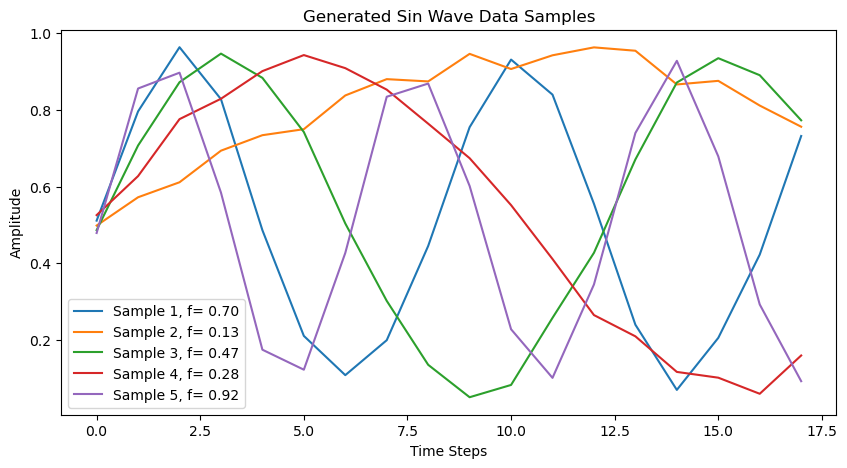

In [242]:
# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X_train[i], label=f"Sample {i+1}, f= {y_train[i][0]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [243]:
seq_len = X_train.shape[1]
hparams = {
    "kernel_size": (n_features := 4),  # =1D kernel size
    "input_length": seq_len,
    "stride": 3,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
    "dropout": 0.1,  # dropout bate
    "conv1_channels": 5,
}

CNN_classical = CNN_1D(hparams=hparams)

In [244]:
# change model to float64
CNN_classical = CNN_classical.double()

# number of trainable parameters
n_params = sum(p.numel() for p in CNN_classical.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {n_params}")

Number of trainable parameters: 146


In [245]:
y_val = torch.tensor(y_val, dtype=torch.float64)
if len(y_val.shape) == 2:
    y_val = y_val.squeeze(1)

# train the model
batch_size = 16
epochs = 50
loss_hist = []
loss_hist_val = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
CNN_classical.train()
optimizer = torch.optim.Adam(
    CNN_classical.parameters(), lr=0.01, weight_decay=1e-5
)
params_hist = [copy.deepcopy(p) for p in CNN_classical.parameters()]
for epoch in range(epochs):
    CNN_classical.train()
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}", leave=False):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64).reshape(
            -1, 1, seq_len
        )
        y_batch = torch.tensor(
            y_train[i : i + batch_size], dtype=torch.float64
        ).squeeze(1)
        batch_out = CNN_classical(x_batch)  # (batch_size, 1, seq_len)
        # predicted = torch.stack([bo["output"] for bo in batch_out])
        predicted = batch_out
        loss = loss_fn(predicted.squeeze(1), y_batch)
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append([copy.deepcopy(p) for p in CNN_classical.parameters()])
    epoch_loss = np.mean(epoch_losses)

    # validation
    CNN_classical.eval()
    with torch.no_grad():
        x_val = torch.tensor(X_val, dtype=torch.float64).reshape(-1, 1, seq_len)
        val_out = CNN_classical(x_val)
        val_loss = loss_fn(val_out.squeeze(1), y_val)
        loss_hist_val.append(val_loss.item())
        tqdm.write(f"Epoch {epoch+1} train RMSE: {np.sqrt(epoch_loss):.4f}, "
                   f"val RMSE: {np.sqrt(val_loss.item()):.4f}")

loss_hist = np.array(loss_hist)
print(f"Final loss (MSE): {loss_hist[-1]}")
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train RMSE: 0.8203, val RMSE: 0.6784


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 train RMSE: 0.4993, val RMSE: 0.3154


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 train RMSE: 0.3986, val RMSE: 0.3089


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 train RMSE: 0.3832, val RMSE: 0.3031


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 train RMSE: 0.3430, val RMSE: 0.2841


Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 train RMSE: 0.2980, val RMSE: 0.2915


Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 train RMSE: 0.2981, val RMSE: 0.2677


Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 train RMSE: 0.3311, val RMSE: 0.2537


Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 train RMSE: 0.2703, val RMSE: 0.2282


Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 train RMSE: 0.2508, val RMSE: 0.2031


Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 train RMSE: 0.1994, val RMSE: 0.1757


Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 train RMSE: 0.2174, val RMSE: 0.1234


Epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 train RMSE: 0.2171, val RMSE: 0.1119


Epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 train RMSE: 0.1628, val RMSE: 0.0895


Epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 train RMSE: 0.1475, val RMSE: 0.0635


Epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 train RMSE: 0.1749, val RMSE: 0.0804


Epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 train RMSE: 0.1547, val RMSE: 0.0591


Epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 train RMSE: 0.1760, val RMSE: 0.0650


Epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 train RMSE: 0.1887, val RMSE: 0.0649


Epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 train RMSE: 0.1627, val RMSE: 0.0569


Epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 train RMSE: 0.1564, val RMSE: 0.0568


Epoch 22:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 train RMSE: 0.1748, val RMSE: 0.0558


Epoch 23:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 train RMSE: 0.1503, val RMSE: 0.0990


Epoch 24:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 train RMSE: 0.1297, val RMSE: 0.0553


Epoch 25:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25 train RMSE: 0.1400, val RMSE: 0.0492


Epoch 26:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26 train RMSE: 0.1414, val RMSE: 0.0535


Epoch 27:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27 train RMSE: 0.1460, val RMSE: 0.0347


Epoch 28:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28 train RMSE: 0.1666, val RMSE: 0.0774


Epoch 29:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29 train RMSE: 0.1366, val RMSE: 0.0475


Epoch 30:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30 train RMSE: 0.1164, val RMSE: 0.0675


Epoch 31:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31 train RMSE: 0.1125, val RMSE: 0.0630


Epoch 32:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32 train RMSE: 0.1192, val RMSE: 0.0654


Epoch 33:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33 train RMSE: 0.1433, val RMSE: 0.0524


Epoch 34:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34 train RMSE: 0.1133, val RMSE: 0.0617


Epoch 35:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35 train RMSE: 0.0978, val RMSE: 0.0627


Epoch 36:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36 train RMSE: 0.1208, val RMSE: 0.0486


Epoch 37:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37 train RMSE: 0.1167, val RMSE: 0.0615


Epoch 38:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38 train RMSE: 0.1206, val RMSE: 0.0564


Epoch 39:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39 train RMSE: 0.1201, val RMSE: 0.0571


Epoch 40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40 train RMSE: 0.1193, val RMSE: 0.0485


Epoch 41:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41 train RMSE: 0.1120, val RMSE: 0.0644


Epoch 42:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42 train RMSE: 0.1113, val RMSE: 0.0675


Epoch 43:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43 train RMSE: 0.1058, val RMSE: 0.0378


Epoch 44:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44 train RMSE: 0.1095, val RMSE: 0.0583


Epoch 45:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45 train RMSE: 0.1219, val RMSE: 0.0395


Epoch 46:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46 train RMSE: 0.1104, val RMSE: 0.0490


Epoch 47:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47 train RMSE: 0.1026, val RMSE: 0.0552


Epoch 48:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48 train RMSE: 0.1219, val RMSE: 0.0392


Epoch 49:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49 train RMSE: 0.1144, val RMSE: 0.0488


Epoch 50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50 train RMSE: 0.1186, val RMSE: 0.0491
Final loss (MSE): 0.04839440430204387
Final loss (RMSE): 0.21998728213704508


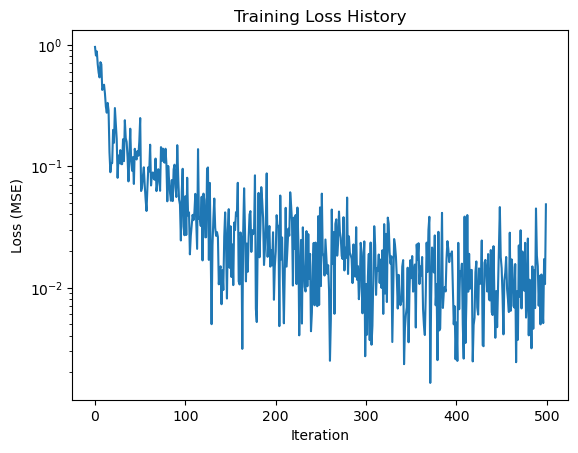

In [246]:
plt.plot(loss_hist)
plt.title("Training Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.yscale("log")
plt.show()

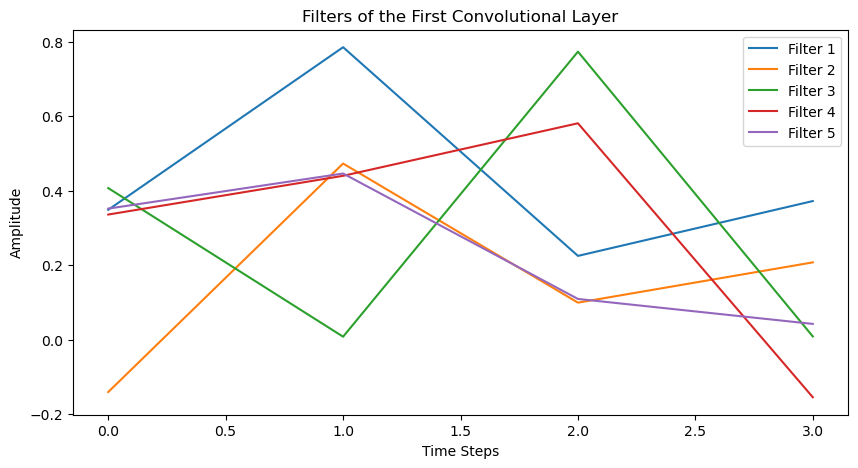

In [247]:
# plot the filters of the first convolutional layer
conv1_weights = CNN_classical.conv1.weight.data.cpu().numpy()
plt.figure(figsize=(10, 5))
for i in range(conv1_weights.shape[0]):
    plt.plot(conv1_weights[i, 0, :], label=f"Filter {i+1}")
plt.title("Filters of the First Convolutional Layer")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [248]:
# test the model
CNN_classical.eval()
y_pred_test = []
with torch.no_grad():
    x_test = torch.tensor(X_test, dtype=torch.float64).reshape(-1, 1, seq_len)  # (batch_size, 1, seq_len)
    y_test_tmp = torch.tensor(y_test, dtype=torch.float64).squeeze(1)
    predicted = CNN_classical(x_test).squeeze(1)  # (batch_size, 1, seq_len)
    y_pred_test.append(predicted.numpy())
    test_loss = loss_fn(predicted, y_test_tmp)
    print(f"Test loss (MSE): {test_loss.item()}")
    print(f"Test loss (RMSE): {np.sqrt(test_loss.item())}")
y_pred_test = np.concatenate(y_pred_test, axis=0)

Test loss (MSE): 0.002025101833799403
Test loss (RMSE): 0.04500113147243526


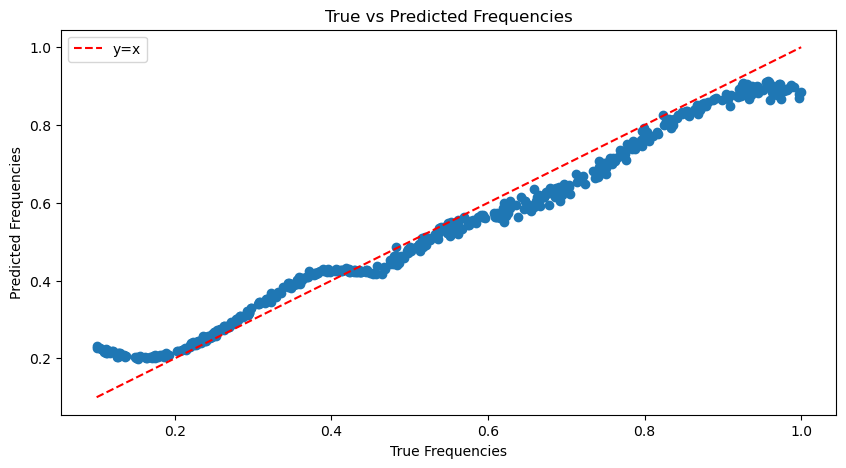

In [13]:
# plot the results
plt.figure(figsize=(10, 5))
plt.scatter(y_test_tmp, predicted.numpy())
# diagonal line
plt.plot([y_test_tmp.min(), y_test_tmp.max()], [y_test_tmp.min(), y_test_tmp.max()], 'r--', label='y=x')
plt.title("True vs Predicted Frequencies")
plt.xlabel("True Frequencies")
plt.ylabel("Predicted Frequencies")
plt.legend()
plt.show()

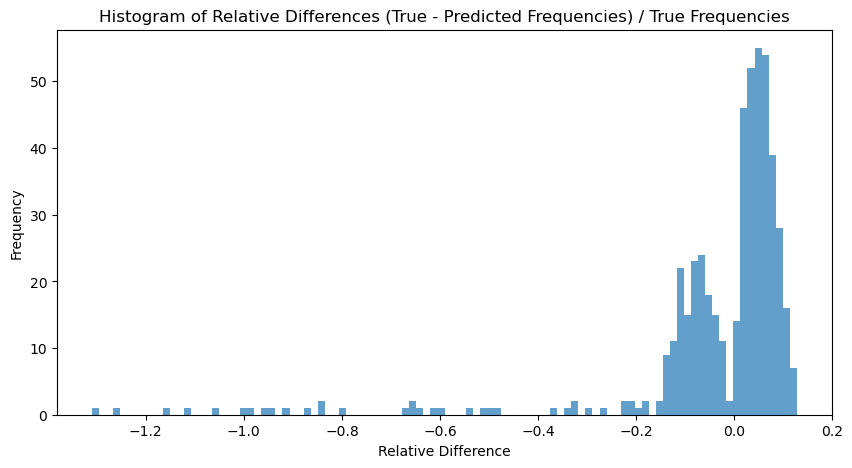

In [14]:
diffs = y_test.squeeze(1) - y_pred_test
rel_diffs = diffs / y_test.squeeze(1)  # relative differences
# histogram of the differences
plt.figure(figsize=(10, 5))
plt.hist(rel_diffs, bins=100, alpha=0.7)
plt.title("Histogram of Relative Differences (True - Predicted Frequencies) / True Frequencies")
plt.xlabel("Relative Difference")
plt.ylabel("Frequency")
plt.show()

In [15]:
import pickle
# save training history
os.makedirs("losses_hist", exist_ok=True)
with open("losses_hist/classical_CNN_kernel_size_4_sin_train_hist.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "params_hist": params_hist,
            "hparams": hparams,
            test_loss.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )

# With Learned Channel Collapse

In [16]:
from source.NAHEA_CNN import CNN_1D_Learned_Channel_Collapse

In [17]:
seq_len = X_train.shape[1]
hparams = {
    "kernel_size": (n_features := 4),  # =1D kernel size
    "input_length": seq_len,
    "stride": 3,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
    "dropout": 0.1,  # dropout bate
    "conv1_channels": 4,
}

CNN_classical_2 = CNN_1D_Learned_Channel_Collapse(hparams=hparams)
CNN_classical_2 = CNN_classical_2.double()

In [18]:
n_params = sum(p.numel() for p in CNN_classical_2.parameters() if p.requires_grad)
print(f"Number of learned parameters: {n_params}")

Number of learned parameters: 146


In [19]:
y_val = torch.tensor(y_val, dtype=torch.float64)
if len(y_val.shape) == 2:
    y_val = y_val.squeeze(1)

# train the model
batch_size = 16
epochs = 50
loss_hist = []
loss_hist_val = []
loss_fn = torch.nn.MSELoss()
CNN_classical_2.train()
optimizer = torch.optim.Adam(
    CNN_classical_2.parameters(), lr=0.01, weight_decay=1e-5
)
params_hist = [copy.deepcopy(p) for p in CNN_classical_2.parameters()]
for epoch in range(epochs):
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}", leave=False):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64).reshape(
            -1, 1, seq_len
        )
        y_batch = torch.tensor(
            y_train[i : i + batch_size], dtype=torch.float64
        ).squeeze(1)
        batch_out = CNN_classical_2(x_batch)  # (batch_size, 1, seq_len)
        # predicted = torch.stack([bo["output"] for bo in batch_out])
        predicted = batch_out
        loss = loss_fn(predicted.squeeze(1), y_batch)
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append([copy.deepcopy(p) for p in CNN_classical_2.parameters()])
    epoch_loss = np.mean(epoch_losses)

    # validation
    CNN_classical_2.eval()
    with torch.no_grad():
        x_val = torch.tensor(X_val, dtype=torch.float64).reshape(-1, 1, seq_len)
        val_out = CNN_classical_2(x_val)
        val_loss = loss_fn(val_out.squeeze(1), y_val)
        loss_hist_val.append(val_loss.item())
        tqdm.write(f"Epoch {epoch+1} train RMSE: {np.sqrt(epoch_loss):.4f}, "
                   f"val RMSE: {np.sqrt(val_loss.item()):.4f}")
loss_hist = np.array(loss_hist)
print(f"Final loss (MSE): {loss_hist[-1]}")
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")

/tmp/ipykernel_215315/4175809920.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val = torch.tensor(y_val, dtype=torch.float64)


Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train RMSE: 0.4579, val RMSE: 0.2978


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 train RMSE: 0.2602, val RMSE: 0.2733


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 train RMSE: 0.2374, val RMSE: 0.2235


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 train RMSE: 0.1969, val RMSE: 0.2025


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 train RMSE: 0.1693, val RMSE: 0.1434


Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 train RMSE: 0.1292, val RMSE: 0.1123


Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 train RMSE: 0.0768, val RMSE: 0.0754


Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 train RMSE: 0.0644, val RMSE: 0.0558


Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 train RMSE: 0.0573, val RMSE: 0.0542


Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 train RMSE: 0.0579, val RMSE: 0.0504


Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 train RMSE: 0.0538, val RMSE: 0.0559


Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 train RMSE: 0.0481, val RMSE: 0.0453


Epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 train RMSE: 0.0433, val RMSE: 0.0425


Epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 train RMSE: 0.0420, val RMSE: 0.0405


Epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 train RMSE: 0.0415, val RMSE: 0.0419


Epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 train RMSE: 0.0414, val RMSE: 0.0378


Epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 train RMSE: 0.0389, val RMSE: 0.0365


Epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 train RMSE: 0.0361, val RMSE: 0.0376


Epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 train RMSE: 0.0353, val RMSE: 0.0332


Epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 train RMSE: 0.0369, val RMSE: 0.0354


Epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 train RMSE: 0.0350, val RMSE: 0.0322


Epoch 22:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 train RMSE: 0.0336, val RMSE: 0.0321


Epoch 23:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 train RMSE: 0.0324, val RMSE: 0.0303


Epoch 24:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 train RMSE: 0.0324, val RMSE: 0.0306


Epoch 25:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25 train RMSE: 0.0305, val RMSE: 0.0294


Epoch 26:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26 train RMSE: 0.0309, val RMSE: 0.0300


Epoch 27:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27 train RMSE: 0.0332, val RMSE: 0.0360


Epoch 28:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28 train RMSE: 0.0354, val RMSE: 0.0338


Epoch 29:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29 train RMSE: 0.0315, val RMSE: 0.0278


Epoch 30:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30 train RMSE: 0.0285, val RMSE: 0.0284


Epoch 31:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31 train RMSE: 0.0290, val RMSE: 0.0259


Epoch 32:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32 train RMSE: 0.0287, val RMSE: 0.0256


Epoch 33:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33 train RMSE: 0.0271, val RMSE: 0.0268


Epoch 34:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34 train RMSE: 0.0265, val RMSE: 0.0250


Epoch 35:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35 train RMSE: 0.0267, val RMSE: 0.0270


Epoch 36:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36 train RMSE: 0.0269, val RMSE: 0.0243


Epoch 37:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37 train RMSE: 0.0255, val RMSE: 0.0249


Epoch 38:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38 train RMSE: 0.0254, val RMSE: 0.0237


Epoch 39:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39 train RMSE: 0.0265, val RMSE: 0.0241


Epoch 40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40 train RMSE: 0.0234, val RMSE: 0.0248


Epoch 41:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41 train RMSE: 0.0229, val RMSE: 0.0228


Epoch 42:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42 train RMSE: 0.0256, val RMSE: 0.0254


Epoch 43:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43 train RMSE: 0.0250, val RMSE: 0.0234


Epoch 44:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44 train RMSE: 0.0218, val RMSE: 0.0240


Epoch 45:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45 train RMSE: 0.0231, val RMSE: 0.0228


Epoch 46:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46 train RMSE: 0.0228, val RMSE: 0.0230


Epoch 47:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47 train RMSE: 0.0244, val RMSE: 0.0231


Epoch 48:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48 train RMSE: 0.0247, val RMSE: 0.0235


Epoch 49:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49 train RMSE: 0.0246, val RMSE: 0.0279


Epoch 50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50 train RMSE: 0.0272, val RMSE: 0.0233
Final loss (MSE): 0.00040485583819344366
Final loss (RMSE): 0.020121029749827508


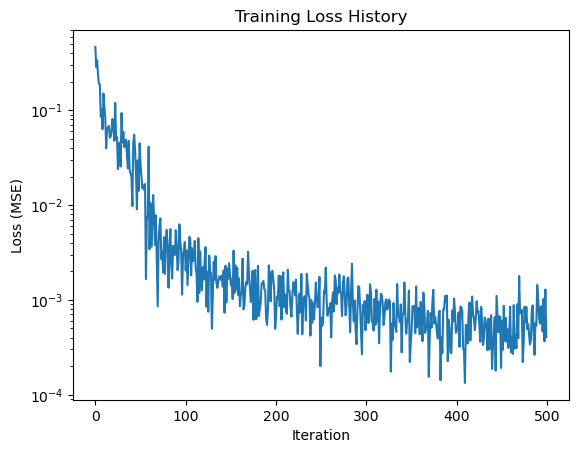

In [20]:
plt.plot(loss_hist)
plt.title("Training Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.yscale("log")
plt.show()

In [21]:
# test the model
CNN_classical_2.eval()
y_pred_test = []
with torch.no_grad():
    x_test = torch.tensor(X_test, dtype=torch.float64).reshape(-1, 1, seq_len)  # (batch_size, 1, seq_len)
    y_test_tmp = torch.tensor(y_test, dtype=torch.float64).squeeze(1)
    predicted = CNN_classical_2(x_test).squeeze(1)  # (batch_size, 1, seq_len)
    y_pred_test.append(predicted.numpy())
    test_loss = loss_fn(predicted, y_test_tmp)
    print(f"Test loss (MSE): {test_loss.item()}")
    print(f"Test loss (RMSE): {np.sqrt(test_loss.item())}")
y_pred_test = np.concatenate(y_pred_test, axis=0)

Test loss (MSE): 0.0006947468920673203
Test loss (RMSE): 0.026358051750220848


In [22]:
import pickle
# save training history
os.makedirs("losses_hist", exist_ok=True)
with open("losses_hist/classical_CNN_kernel_size_4_sin_Learned_Channel_Collpase_train_hist.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "params_hist": params_hist,
            "hparams": hparams,
            test_loss.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )